In [15]:

import sys
sys.path.append('../Scripts')
from PostProcessingScripts import * 


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd

In [2]:
markershapes = ["*", "o", "v",  "p", "H", "^", ">", 'X', "+","<", 'x', "3","d","1", "|", "D", "P", "X", "+", "d"]
dictMarkerShape = {BPSnameslist[i]: markershapes[i] for i in range(len(BPSnameslist))}

In [4]:
# list_MRR_GWs = ['GW151226', 'GW191103_012549', 'GW191126_115259']
# list_MRR_GWs_candidates = []


# GW170729
# 'GW190517_055101'


# extreme q 
# GW190412 and GW190517_055101 (q~1)


# low significance: GW190403_051519
    
#  Colored points show the 90% credible intervals
#  GW190403_051519 (orange), GW190412 (red), GW190517_055101
# (cyan), and GW191109_010717 (pink). 

In [13]:
def plot_3Msun_lines(axes, xlim=[1,100]):
    
    # m1 = 3 Msun 
    q = np.linspace(0, 1, 100)
    m1 = 3
    mtot = (q+1) * m1
    
    axes.plot(mtot, q, c='gray', lw=2, linestyle=':', zorder=1E4)
    axes.text(mtot[11], q[10], s=r'$m_1 = 3 \, \rm{M}_{\odot}$', fontsize=fs-6, rotation=72, va='bottom', ha='center')
        
    # m2 = 3 Msun 
    q=np.linspace(0.001, 1, 100)
    m2 = 3 # Msun 
    mtot = (1+(1/q))*m2
    axes.plot(mtot, q, c='gray', lw=2, linestyle=':', zorder=1E4)
    axes.text(mtot[2], q[3], s=r'$m_2 = 3 \, \rm{M}_{\odot}$', fontsize=fs-6, rotation=-3)
    
    

    return

def make_up_axes(axes=None, xlim=[2,400], ylim=[0,1], xlabel=r'Total mass $[M_{\odot}]$', ylabel=r'q', logX=True,  logY=False):
    
    
    if (xlabel!=None) & (ylabel!=None):
        layoutAxes(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)
    elif xlabel==None:
        layoutAxesNoXlabel(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)
    elif ylabel==None:
        layoutAxesNoYlabel(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)    
        
    axes.set_xlim(xlim[0],xlim[1])
    axes.set_ylim(ylim[0], ylim[1])
    
    if logX!=False:
        axes.set_xscale('log')     
    if logY!=False:
        axes.set_yscale('log')       
    return 




def plot_x_ticks(axe=None, xtick_loc=[1, 2, 4, 7, 10, 20, 40, 70, 100, 200, 400], ytick_loc=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], xlim=[2,400], ylim=[0,1]):
    

    
    xtick_name = []
    for ind, xtick in enumerate(xtick_loc):
        xtick_name.append(r'$\textbf{%s}$'%str(xtick))
        axe.plot(np.ones(100)*xtick, np.linspace(ylim[0], ylim[1], 100), c='lightgray', lw=1.2, linestyle='-', zorder=0)
    
    axe.set_xticks(xtick_loc)
    axe.set_xticklabels(xtick_name, fontsize=fs, rotation=0)#, orientation=30) 
    
    
    ytick_name = []
    for ind, ytick in enumerate(ytick_loc):
        ytick_name.append(r'$\textbf{%s}$'%str(ytick))
        axe.plot(np.linspace(xlim[0], xlim[1], 100), np.ones(100)*ytick, c='lightgray', lw=1.2, linestyle='-', zorder=0)
    
    axe.set_yticks(ytick_loc)
    axe.set_yticklabels(ytick_name, fontsize=fs, rotation=0)#, orientation=30)  
    
    axe.set_xlim(xlim[0], xlim[1])
    axe.set_ylim(ylim[0], ylim[1])

    return 







def plot_Fig_GWTC(axe, xparam='chiEff', BPSmodelName='A', mssfr='112'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      


    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

#     del massCO_ZAMSM1
#     del massCO_ZAMSM2
    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO

    spin = COspin(data_path=path, state='he_depletion')  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

    spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
    spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
    spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

    # spin_threshold = 0.05 # definition of "spinning BH"
    mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) # more massive = spinning: MRR 
    mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # less nassuve BH = spinning (Non MRR)
    mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )        

    
    
    ### read in MSSFR weights: ###
    # get detected weights
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    weights_ = fdata[fparam_key][weightheader][...].squeeze()
    w = weights_
    


    if xparam=='ChiEff_vs_q':
        axe.set_xlim(-1, 1)
        axe.set_ylim(0, 1)  
        chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chi_eff
        param_y = MassRatioCO_LVK
        nameX = r'$\chi_{\rm{eff}}$'
        nameY = r'$q$'
        
        
    elif xparam=='Mtot_vs_q':

        param_x = massCO_ZAMSM1 + massCO_ZAMSM2
        param_y = MassRatioCO_LVK
        

    if BPSmodelName in ['A','B', 'J', 'K', 'R']:
        color_BPS = [colorDirDict[BPSmodelName]]
        zorder=10     
    else:
        color_BPS ='gray'
        zorder=9
    
    NN_ = 1000
    size_ = 100

#     axe.scatter(param_x[mask_MRR][:NN_], param_y[mask_MRR][:NN_], s=size_*w[mask_MRR][:NN_], marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 
    axe.scatter(param_x[mask_LVKM1_spinning][:NN_], param_y[mask_LVKM1_spinning][:NN_], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 

    
    
    
    
 
    
    return axe












we find for parameter spin1 the 90 and median: 
[0.13145214 0.5676573  0.92356002]

we find for parameter spin2 the 90 and median: 
[0.05207294 0.50273832 0.94262437]


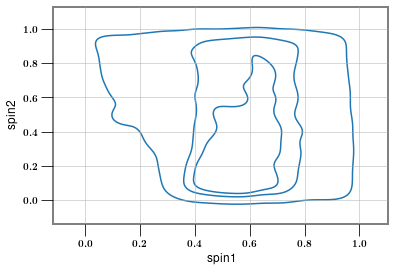

In [34]:
GW_name='GW151226'
dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_name  + '.csv' 


df = pd.read_csv(dfCSVname_, index_col=0, skiprows=[1])
mass_ratio = df['M2']/df['M1']
total_mass = df['M2'] + df['M1']
spin1 = df['spin1'] 
spin2 = df['spin2'] 

y_quantiles = [0.05, 0.5, 0.95]
xvar_quantiles = weighted_quantile(values=spin1, quantiles=y_quantiles)    
print('we find for parameter spin1 the 90 and median: ')
print(xvar_quantiles)


print()

xvar_quantiles = weighted_quantile(values=spin2, quantiles=y_quantiles)    
print('we find for parameter spin2 the 90 and median: ')
print(xvar_quantiles)


def plot_GW_contours(axe, xparam):
    
    
    sns.kdeplot(x=total_mass, y=mass_ratio, levels=[0.1], zorder=11, color='k')
    


    
sns.kdeplot(x=spin1, y=spin2,levels=[0.1, 0.5, 0.75])
plt.show()

now at model A
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model B
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model C
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model D
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model E
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model F
140  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model G
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model H
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model I
0  systems had negative spin because they are outside o

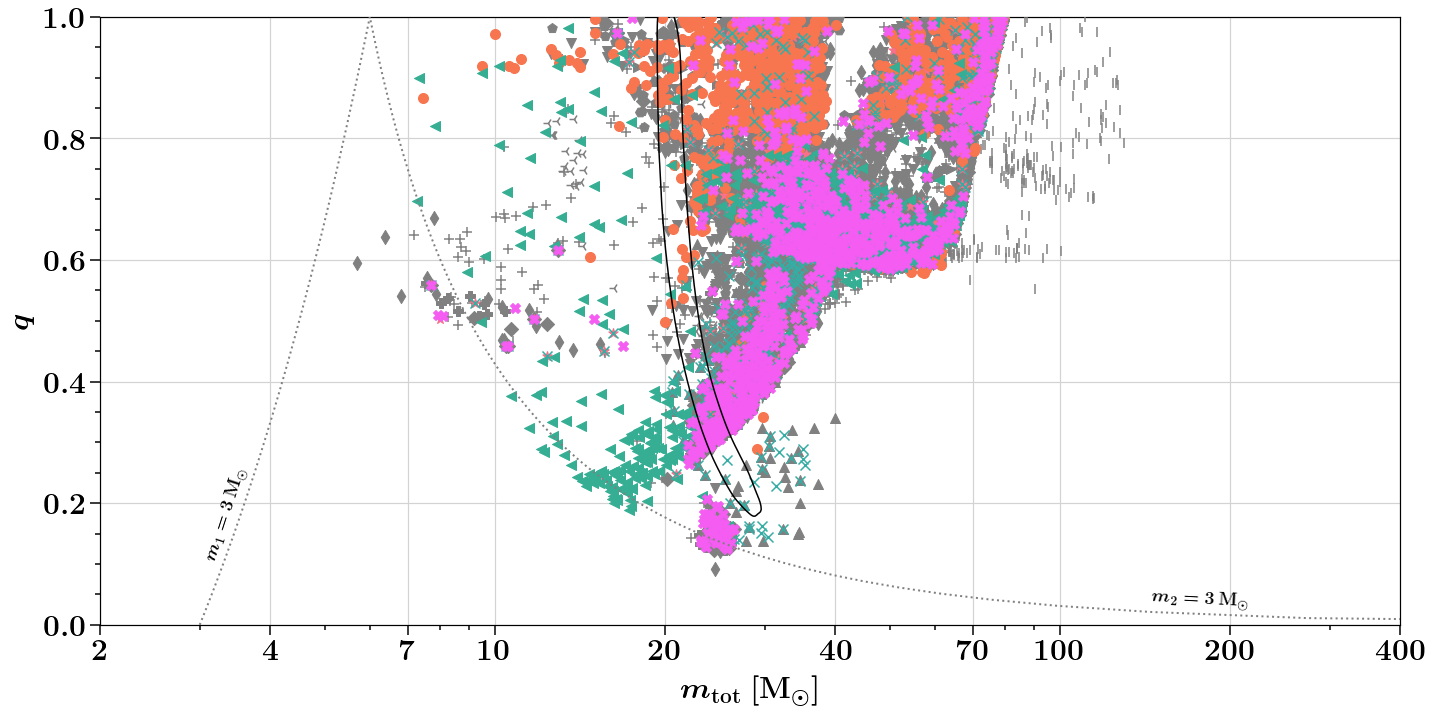

In [19]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:

fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,1, figsize=(20,10))
spin_threshold=0.05

make_up_axes(axes=axe) 
plot_x_ticks(axe=axe) # has to go after make_up_axes  

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'
axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l+10)


plot_GW_contours(axe=axe, xparam='Mtot_vs_q')


for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.



    _ = plot_Fig_GWTC(axe=axe, xparam='Mtot_vs_q', BPSmodelName=model, mssfr=mssfr)


    
   

axe.set_xlim(2, 400)
axe.set_ylim(0, 1)  
plot_3Msun_lines(axes=axe, xlim=[2,400])


    


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)

fig.tight_layout() 
plt.savefig('./Mtot_vs_q_all_models.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show()      

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const


from matplotlib import rc                                                                                                                                                                                                                    
from matplotlib import rcParams
rc('font', family='serif', weight = 'bold')
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rc('axes', linewidth=2)

matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
matplotlib.rcParams['font.weight']= 'bold'
# matplotlib.rcParams.update({'font.weight': 'bold'})
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

fs = 24 # fontsize for plots
rc('axes', linewidth=2)



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


%matplotlib inline
import pesummary
from pesummary.io import read
print(pesummary.__version__)
import h5py
# %config InlineBackend.figure_format = 'retina'

import astropy.cosmology
from astropy import units
from astropy import constants as c
from astropy import units as u
import pycbc.conversions
import numpy
import h5py as h5

import pandas as pd



%matplotlib inline
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  


0.13.0


In [28]:
def get_cosmology(cosmology=None, **kwargs):
    r"""Gets an astropy cosmology class.

    Parameters
    ----------
    cosmology : str or astropy.cosmology.FlatLambdaCDM, optional
        The name of the cosmology to use. For the list of options, see
        :py:attr:`astropy.cosmology.parameters.available`. If None, and no
        other keyword arguments are provided, will default to
        :py:attr:`DEFAULT_COSMOLOGY`. If an instance of
        :py:class:`astropy.cosmology.FlatLambdaCDM`, will just return that.
    \**kwargs :
        If any other keyword arguments are provided they will be passed to
        :py:attr:`astropy.cosmology.FlatLambdaCDM` to create a custom
        cosmology.

    Returns
    -------
    astropy.cosmology.FlatLambdaCDM
        The cosmology to use.

    Examples
    --------
    Use the default:

    >>> from pycbc.cosmology import get_cosmology
    >>> get_cosmology()
    FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307,
                  Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV,
                  Ob0=0.0486)

    Use properties measured by WMAP instead:

    >>> get_cosmology("WMAP9")
    FlatLambdaCDM(name="WMAP9", H0=69.3 km / (Mpc s), Om0=0.286, Tcmb0=2.725 K,
                  Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0463)

    Create your own cosmology (see :py:class:`astropy.cosmology.FlatLambdaCDM`
    for details on the default values used):

    >>> get_cosmology(H0=70., Om0=0.3)
    FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None,
                  Ob0=None)

    """
    if kwargs and cosmology is not None:
        raise ValueError("if providing custom cosmological parameters, do "
                         "not provide a `cosmology` argument")
    if isinstance(cosmology, astropy.cosmology.FlatLambdaCDM):
        # just return
        return cosmology
    if kwargs:
        cosmology = astropy.cosmology.FlatLambdaCDM(**kwargs)
    else:
        if cosmology is None:
            cosmology = DEFAULT_COSMOLOGY
        if cosmology not in astropy.cosmology.parameters.available:
            raise ValueError("unrecognized cosmology {}".format(cosmology))
        cosmology = getattr(astropy.cosmology, cosmology)
    return cosmology


def z_at_value(func, fval, unit, zmax=1000., **kwargs):
    r"""Wrapper around astropy.cosmology.z_at_value to handle numpy arrays.

    Getting a z for a cosmological quantity involves numerically inverting
    ``func``. The ``zmax`` argument sets how large of a z to guess (see
    :py:func:`astropy.cosmology.z_at_value` for details). If a z is larger than
    ``zmax``, this will try a larger zmax up to ``zmax * 10**5``. If that still
    is not large enough, will just return ``numpy.inf``.

    Parameters
    ----------
    func : function or method
        A function that takes redshift as input.
    fval : float
        The value of ``func(z)``.
    unit : astropy.unit
        The unit of ``fval``.
    zmax : float, optional
        The initial maximum search limit for ``z``. Default is 1000.
    \**kwargs :
        All other keyword arguments are passed to
        :py:func:``astropy.cosmology.z_at_value``.

    Returns
    -------
    float
        The redshift at the requested values.
    """
    fval, input_is_array = pycbc.conversions.ensurearray(fval)
    # make sure fval is atleast 1D
    if fval.size == 1 and fval.ndim == 0:
        fval = fval.reshape(1)
    zs = numpy.zeros(fval.shape, dtype=float)  # the output array
    for (ii, val) in enumerate(fval):
        try:
            zs[ii] = astropy.cosmology.z_at_value(func, val*unit, zmax=zmax,
                                                  **kwargs)
        except CosmologyError:
            # we'll get this if the z was larger than zmax; in that case we'll
            # try bumping up zmax later to get a value
            zs[ii] = numpy.inf
    # check if there were any zs > zmax
    replacemask = numpy.isinf(zs)
    # try bumping up zmax to get a result
    if replacemask.any():
        # we'll keep bumping up the maxz until we can get a result
        counter = 0  # to prevent running forever
        while replacemask.any():
            kwargs['zmin'] = zmax
            zmax = 10 * zmax
            idx = numpy.where(replacemask)
            for ii in idx:
                val = fval[ii]
                try:
                    zs[ii] = astropy.cosmology.z_at_value(
                        func, val*unit, zmax=zmax, **kwargs)
                    replacemask[ii] = False
                except CosmologyError:
                    # didn't work, try on next loop
                    pass
            counter += 1
            if counter == 5:
                # give up and warn the user
                logging.warning("One or more values correspond to a "
                                "redshift > {0:.1e}. The redshift for these "
                                "have been set to inf. If you would like "
                                "better precision, call God.".format(zmax))
                break
    return pycbc.conversions.formatreturn(zs, input_is_array)


def _redshift(distance, **kwargs):
    r"""Uses astropy to get redshift from the given luminosity distance.

    Parameters
    ----------
    distance : float
        The luminosity distance, in Mpc.
    \**kwargs :
        All other keyword args are passed to :py:func:`get_cosmology` to
        select a cosmology. If none provided, will use
        :py:attr:`DEFAULT_COSMOLOGY`.

    Returns
    -------
    float :
        The redshift corresponding to the given luminosity distance.
    """
    cosmology = get_cosmology(cosmology='WMAP9')
    return z_at_value(cosmology.luminosity_distance, distance, units.Mpc)

In [29]:

BBHsGWTC1 = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170818', 'GW170823']
BBHsGWTC2 = ['GW190408_181802','GW190412','GW190413_052954','GW190413_134308','GW190421_213856',\
'GW190424_180648','GW190503_185404','GW190512_180714',\
'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544','GW190521_074359',\
'GW190521','GW190527_092055','GW190602_175927','GW190620_030421','GW190630_185205','GW190701_203306',\
'GW190706_222641','GW190707_093326','GW190708_232457','GW190720_000836',\
'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701','GW190828_063405',\
'GW190828_065509','GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',\
 'GW190930_133541']

BHNSGWTC2 = ['GW190425', 'GW190814', 'GW190426_152155']
BNSGWTC1 = ['GW170817']
BNSGWTC2 = ['GW190425']

In [ ]:
['GW151226','GW170729', 'GW190517_055101']

In [38]:

# list_MRR_GWs = ['GW151226', 'GW191103_012549', 'GW191126_115259']
# list_MRR_GWs_candidates = []


# GW170729
# 'GW190517_055101'


# extreme q 
# GW190412 and GW190517_055101 (q~1)


# low significance: GW190403_051519
    
#  Colored points show the 90% credible intervals
#  GW190403_051519 (orange), GW190412 (red), GW190517_055101
# (cyan), and GW191109_010717 (pink). 


def get_credible_GW(GW_name, dfCSVname):
    
    # the quantiles we want to obtain, here: the median & 90% credible interval
    # so we want quantiles 0.05, 0.5 and 0.95
    y_quantiles  =  [0.05,   0.5,    0.95]   
    indexnames   = ['unit',  '0.05',  '0.5',  '0.95']
    
    # prepare DataFrame 
    xvarHeaders = ['Mass1', 'Mass2', \
                    'TotMass', 'ChirpMass', 'q', 'spin1', 'spin2', 'final_spin', 'final_mass_source' ]

    xvarUnits = ['Msun', 'Msun', 'Msun', 'Msun', '#', '#', '#', '#', 'Msun']
    
    # ALL GWTC per catalog 
    GWTC1_BNS = ['GW170817']
    GWTC1 = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170817',  'GW170818', 'GW170823']
    GWTC2 = ['GW190408_181802','GW190412','GW190413_052954','GW190413_134308','GW190421_213856',\
    'GW190424_180648','GW190503_185404','GW190512_180714',\
    'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544','GW190521_074359',\
    'GW190521','GW190527_092055','GW190602_175927','GW190620_030421','GW190630_185205','GW190701_203306',\
    'GW190706_222641','GW190707_093326','GW190708_232457','GW190720_000836',\
    'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701','GW190828_063405',\
    'GW190828_065509','GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',\
     'GW190930_133541', 'GW190425', 'GW190814', 'GW190426_152155']
    
    
    
    
    for GW in [GW_name]:
        GW_ = str(GW)
        if GW in GWTC1:
            print(GW_)
            GW_file = '/Volumes/Andromeda2/GWTC-1_LVK_catalog/GWTC-1_sample_release/'+GW_+'_GWTC-1.hdf5'
            GW_hdf5 = h5.File(GW_file, 'r')
            
            # GW170817 does not have an overall posterior, but insteaad low & high spin. we choose low spin. 
            if GW_ in GWTC1_BNS:
                detM1 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['m1_detector_frame_Msun']
                detM2 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['m2_detector_frame_Msun']
                LDistance = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['luminosity_distance_Mpc']
                spin1 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['spin1']
                spin2 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['spin2']
                costilt1 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['costilt1']
                costilt2 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['costilt2']


                
                final_spin = GW['IMRPhenomPv2NRT_lowSpin_posterior']['final_spin']
                final_mass_source = GW['IMRPhenomPv2NRT_lowSpin_posterior']['final_mass_source']
                
            else:
#                 print(GW_hdf5['Overall_posterior'].dtype)
                detM1 = GW_hdf5['Overall_posterior']['m1_detector_frame_Msun']
                detM2 = GW_hdf5['Overall_posterior']['m2_detector_frame_Msun']
                LDistance = GW_hdf5['Overall_posterior']['luminosity_distance_Mpc']
                spin1 = GW_hdf5['Overall_posterior']['spin1']
                spin2 = GW_hdf5['Overall_posterior']['spin2']
                costilt1 = GW_hdf5['Overall_posterior']['costilt1']
                costilt2 = GW_hdf5['Overall_posterior']['costilt2']

   
                
                
                
                z_ = _redshift(LDistance)
                # convert to source frame masses
                M1 = detM1 / (1+z_)
                M2 = detM2 / (1+z_)

                mass_1_source = M1 
                mass_2_source = M2
                total_mass_source = M1+M2
                chirp_mass_source = chirpmass(M1, M2)
                symmetric_mass_ratio= M1 / M2
                
#                 final_spin = GW_hdf5['Overall_posterior']['final_spin']
#                 final_mass_source = GW_hdf5['Overall_posterior']['final_mass_source']
                chi_eff = ((spin1 * costilt1 * M1) + (spin2 * costilt2 *  M2)) / (M1 + M2)
    
    
                xvarlist = [M1, M2, chi_eff]
                names = ['Mass 1 ', 'mass 2 ', 'effective spin ']


                # calculate quantiles with bootstrapping (if Nrepeats>1)
                for ind_xvar, xvar in enumerate(xvarlist):
                        # calculate quantiles (credible intervals) from data 
                        xvar_quantiles = weighted_quantile(values=xvar, quantiles=y_quantiles, \
                             sample_weight=np.ones_like(xvar))    
                        print('we find for parameter ', names[ind_xvar], 'the 90 and median: ')
                        print(xvar_quantiles)
                        
                        
                        
#                 print()

            


        
        
        elif GW in GWTC2:

            print(GW_)
            GW_file = '/Volumes/Andromeda2/GWTC-1_LVK_catalog/GWTC-2_sample_release/' + GW_ +'_comoving.h5'
            GW = h5.File(GW_file, 'r')

            data = read(GW_file)
            samples_dict = data.samples_dict
            posterior_samples = samples_dict['PublicationSamples']
#             parameters = sorted(list(posterior_samples.keys()))

            M1 = posterior_samples['mass_1_source']
            M2 = posterior_samples['mass_2_source']
            total_mass_source = posterior_samples['total_mass_source']
            chirp_mass_source= posterior_samples['chirp_mass_source']
            spin1 = posterior_samples['spin_1z']
            spin2 = posterior_samples['spin_2z']
            # our mass ratio is defined the other way around
#             symmetric_mass_ratio = M1 / M2  # is the same as: posterior_samples['inverted_mass_ratio']
            chi_eff = posterior_samples['chi_eff']

#             final_spin = posterior_samples['final_spin']
#             final_mass_source = posterior_samples['final_mass_source']            

    
    
#         ###### write to csv file ######
#         ######                   ######
        xvarlist = [M1, M2, chi_eff, spin1, spin2]
        xvarHeaderlist = ['M1', 'M2', 'chi_eff', 'spin1', 'spin2']

        xvarUnits = ['Msun', 'Msun', '#', '#', '#']
        
        
        
#         # nr of rows and columns that will be used:

        nrows = len(xvarlist[0]) +1  # +1 for units (see below)
        ncol = len(xvarlist)   #* (ncol_MSSFR) # for each MSSFR I want to give quantiles for each xparam 
#         ncol = len(xvarlist[0]) + 1 # +1 for units (see below)
#         nrows = len(xvarlist)   #* (ncol_MSSFR) # for each MSSFR I want to give quantiles for each xparam 
                
        
        
        df_placeholder = np.zeros((nrows, ncol)) # will be filled in loop: 
        print((df_placeholder))
        
        headernames=[]
        units=[]
        for ind_s, ss in enumerate(xvarHeaderlist):
            sss = ss 
            headernames.append(sss)
            units.append(xvarUnits[ind_s])
        print((headernames))
        # store dataFrame with zeros that we will fill on the go:
        dfw = pd.DataFrame(data=df_placeholder, columns=headernames)   
        # add units at first row (index=0)
        dfw.iloc[0]=units        


#         obtain BH and NS masses from combining GW posteriors.
#         by definition LIGO gives Most massive and least massive. 
        for ind_xvar, xvar in enumerate(xvarlist):
            
            dfw_key = headernames[ind_xvar] 
            dfw[dfw_key][1:] = xvar


        dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_  + '.csv' 
        dfw.to_csv(dfCSVname_) 

        print('completed! credible intervals are ready ')
        
        
        
        
        
    return #chi_eff, spin1, spin2, M1, M2






  
    
    

In [31]:

dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
get_credible_GW(GW_name='GW151226', dfCSVname=dfCSVname)
# chi_eff_GW151226, spin1_GW151226, spin2_GW151226, M1_GW151226, M2_GW151226 = get_credible_GW(GW_name='GW151226', dfCSVname=dfCSVname)

GW151226
we find for parameter  Mass 1  the 90 and median: 
[10.46228273 13.69261512 22.44833691]
we find for parameter  mass 2  the 90 and median: 
[5.1181159  7.66278997 9.84836592]
we find for parameter  effective spin  the 90 and median: 
[0.06033515 0.18001728 0.38411512]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
['M1', 'M2', 'chi_eff', 'spin1', 'spin2']
completed! credible intervals are ready 


In [ ]:
x = np.uniform()

'GW190517'
sns.kdeplot()

In [ ]:
['GW151226','GW170729', 'GW190517_055101', 'GW190412']

In [ ]:
for GW_name in ['GW190412']:
    dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
    get_credible_GW(GW_name=GW_name, dfCSVname=dfCSVname)
# chi_eff_GW151226, spin1_GW151226, spin2_GW151226, M1_GW151226, M2_GW151226 = get_credible_GW(GW_name='GW151226', dfCSVname=dfCSVname)

GW190412


In [ ]:
for GW_name in []:
    dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
    get_credible_GW(GW_name=GW_name, dfCSVname=dfCSVname)